# Transfer Learning on LFW Dataset (Grayscale)

## Index
1. Introduction
2. Load and Explore the LFW Dataset
3. Data Preparation (Train/Validation Split)
4. Custom Dataset and Transformations
5. DataLoaders
6. Visualizing Sample Images
7. Using Transfer Learning with ResNet18 (Modified for Grayscale)
8. Training the Final Layer
9. Evaluating the Model (Confusion Matrix & Classification Report)
10. Creating a Prediction Widget
11. Visualizing Model Architecture, Filters, and Feature Maps

---

## 1. Introduction
In this notebook, we use a pre-trained ResNet18 model and adapt it to the grayscale LFW dataset by replicating the single channel three times. We freeze all layers except the last layer, which we retrain for our classes. After training, we evaluate using a confusion matrix and a classification report, then create a widget to upload an image and predict its class.
Finally, we will visualize the ResNet model, show filters from the first convolutional layer (`model.conv1`), show filters and feature maps from a layer in `model.layer1` or `model.layer2`, and also examine the final `fc` layer’s weights.

## 2. Load and Explore the LFW Dataset
We load the dataset and print basic info.

In [5]:
from sklearn.datasets import fetch_openml
import numpy as np

fashion_mnist = fetch_openml(name='Fashion-MNIST', version=1, as_frame=False, parser='auto')

images = fashion_mnist.data.reshape(-1, 28, 28)

labels = fashion_mnist.target.astype(np.uint8)

target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

n_classes = len(target_names)

print("Number of samples:", images.shape[0])
print("Image size:", images.shape[1], "x", images.shape[2])
print("Number of classes:", n_classes)
print("Classes:", target_names)


Number of samples: 70000
Image size: 28 x 28
Number of classes: 10
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## 3. Data Preparation (Train/Validation Split)
Split the dataset into 80% training and 20% validation.

In [6]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets (80% train, 20% validation)
# We use stratify=labels to ensure the class distribution is the same in train and validation sets.
# random_state ensures that the split is the same every time we run the code.
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print("Training samples:", train_images.shape[0])
print("Validation samples:", val_images.shape[0])

Training samples: 56000
Validation samples: 14000


## 4. Custom Dataset and Transformations
We must replicate the grayscale channel to create a pseudo-3-channel image for ResNet. The model expects 3 channels, so we simply copy the single channel into all three. We then apply standard ImageNet normalization.

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import numpy as np

class GrayscaleToRgbDataset(Dataset):
    """
    A custom dataset to convert grayscale images to 3-channel RGB images
    and apply specified transformations.
    """
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        img = img.astype(np.uint8)
        
        img_pil = Image.fromarray(img)        
        img_pil_rgb = img_pil.convert('RGB')        
        if self.transform:
            img_tensor = self.transform(img_pil_rgb)
        else:
            img_np = np.array(img_pil_rgb).transpose((2, 0, 1)) / 255.
            img_tensor = torch.from_numpy(img_np).float()
            
        return img_tensor, torch.tensor(label, dtype=torch.long)

## 5. DataLoaders
Define a transform for ResNet18: resize to 224x224 and apply ImageNet normalization. Then create training and validation loaders.

In [8]:
from typing import Any


transform_resnet = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset = GrayscaleToRgbDataset(train_images, train_labels, transform=transform_resnet)
val_dataset = GrayscaleToRgbDataset(val_images, val_labels, transform=transform_resnet)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 6. Visualizing Sample Images
We visualize some images after transformation (and we define an inverse normalization to see them in a more natural color).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009956302..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009956302..0.99607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009956302..0.9568628].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009956302..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009956302..0.9921568].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009956302..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00995

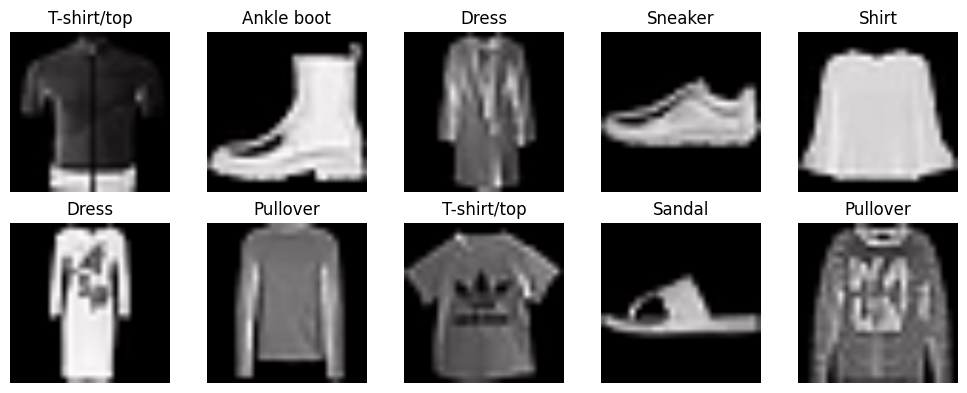

In [9]:
import matplotlib.pyplot as plt
# For plotting.
data_iter = iter(train_loader)
# Get an iterator from train loader.
images_batch, labels_batch = next(data_iter)
# One batch of images and labels.
inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.229, -0.406/0.229],
    std=[1/0.229, 1/0.224, 1/0.225]
)
# Inverse normalization for visualization.
fig, axs = plt.subplots(2,5,figsize=(10,4))
# Create 2x5 grid for 10 images.
for i in range(10):
    ax = axs[i//5, i%5]
    # Determine subplot.
    img = inv_normalize(images_batch[i]).cpu().numpy()
    # Apply inverse normalization.
    img = np.transpose(img, (1,2,0))
    # Rearrange axes to (H,W,C).
    label_idx = labels_batch[i].item()
    # Get label index.
    ax.imshow(img)
    # Show image.
    ax.set_title(target_names[label_idx])
    # Show class name.
    ax.axis('off')
    # Hide axes.
plt.tight_layout()
# Adjust layout.
plt.show()
# Display figure.

## 7. Using Transfer Learning with ResNet18 (Modified for Grayscale)
We load ResNet18 pre-trained on ImageNet. We won't modify its internal layers, but since we provide three identical grayscale channels, it can still process the data.
We freeze all layers except the final fully connected layer and replace it with a new layer for our number of classes. We will only train this final layer.

In [ ]:
import torch.nn as nn
# nn for network layers.
import torch.optim as optim
# optim for optimization.
import torchvision.models as models
# models to load pretrained ResNet.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Device selection.
model = models.resnet18(pretrained=True)
# Load pretrained ResNet18.
for param in model.parameters():
    param.requires_grad = False
    # Freeze all parameters.
num_ftrs = model.fc.in_features
# Get input features of last FC layer.
model.fc = nn.Linear(num_ftrs, n_classes)
# Replace FC layer with a new one.
model = model.to(device)
# Move model to device.
criterion = nn.CrossEntropyLoss()
# Cross-entropy loss.
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Adam optimizer for last layer parameters.

cuda


c:\Users\lidor\Desktop\hit\Deep-Learning-for-Computer-Science-Home-Work\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lidor\Desktop\hit\Deep-Learning-for-Computer-Science-Home-Work\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 8. Training the Final Layer
Train only the last layer for a few epochs.

In [11]:
num_epochs = 10
# Train for 2 epochs.
for epoch in range(num_epochs):
    model.train()
    # Train mode.
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Move data to device.
        optimizer.zero_grad()
        # Reset gradients.
        outputs = model(inputs)
        # Forward pass.
        loss = criterion(outputs, labels)
        # Compute loss.
        loss.backward()
        # Backprop.
        optimizer.step()
        # Update weights of the last layer.
        running_loss += loss.item()
        # Accumulate loss.
    avg_train_loss = running_loss / len(train_loader)
    # Compute average training loss.
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")
    # Print progress.

Epoch 1/10, Train Loss: 0.5790
Epoch 2/10, Train Loss: 0.4346
Epoch 3/10, Train Loss: 0.4125
Epoch 4/10, Train Loss: 0.4006
Epoch 5/10, Train Loss: 0.3959
Epoch 6/10, Train Loss: 0.3895
Epoch 7/10, Train Loss: 0.3841
Epoch 8/10, Train Loss: 0.3807
Epoch 9/10, Train Loss: 0.3757
Epoch 10/10, Train Loss: 0.3769


## 9. Evaluating the Model (Confusion Matrix & Classification Report)
Evaluate on the validation set and print performance metrics.

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
# Import evaluation metrics.
model.eval()
# Eval mode.
all_preds = []
# List for predictions.
all_labels = []
# List for true labels.
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Move data to device.
        outputs = model(inputs)
        # Forward pass.
        _, preds = torch.max(outputs, 1)
        # Get predictions.
        all_preds.extend(preds.cpu().numpy())
        # Store predictions.
        all_labels.extend(labels.cpu().numpy())
        # Store true labels.
cm = confusion_matrix(all_labels, all_preds)
# Compute confusion matrix.
print("Confusion Matrix:\n", cm)
# Print confusion matrix.
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=target_names))
# Print classification report.

Confusion Matrix:
 [[1004    1   56   42   14    3  270    1    9    0]
 [   0 1347    9   30    3    0   10    0    1    0]
 [  12    0 1238   10   61    0   76    0    3    0]
 [  23   10   48 1199   37    1   82    0    0    0]
 [   4    0  180   52 1035    0  129    0    0    0]
 [   0    0    0    0    0 1329    0   55    3   13]
 [ 101    2  194   48  122    1  929    0    3    0]
 [   0    0    0    0    0   37    0 1295    2   66]
 [   2    0   23    6    8   10   16    2 1333    0]
 [   0    0    0    1    0   16    1   44    0 1338]]
Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.88      0.72      0.79      1400
     Trouser       0.99      0.96      0.98      1400
    Pullover       0.71      0.88      0.79      1400
       Dress       0.86      0.86      0.86      1400
        Coat       0.81      0.74      0.77      1400
      Sandal       0.95      0.95      0.95      1400
       Shirt       0.61      0.66      0.64    

## 10. Creating a Prediction Widget
We now add a widget to allow image upload and prediction. We'll replicate the single channel into three channels and use the ResNet transform to predict.

In [17]:
import io
# io for BytesIO.
import ipywidgets as widgets
# Widgets for UI.
from IPython.display import display
# display for showing widgets.

def predict_image(model, img, classes):
    model.eval()
    # Eval mode.
    with torch.no_grad():
        img_rgb = img.convert('RGB')
        # Convert grayscale to 3-channel.
        img_tensor = transform_resnet(img_rgb).unsqueeze(0).to(device)
        # Apply transforms and add batch dim.
        outputs = model(img_tensor)
        # Forward pass.
        _, pred = torch.max(outputs, 1)
        # Get predicted class.
    return classes[pred.item()]
    # Return class name.

upload_button = widgets.FileUpload()
# File upload widget.
predict_button = widgets.Button(description='Predict')
# Button to trigger prediction.
output_box = widgets.Output()
# Output box.

def on_predict_clicked(b):
    if len(upload_button.value) > 0:
        content = list(upload_button.value.values())[0]['content']
        # Get uploaded file bytes.
        img = Image.open(io.BytesIO(content)).convert('L')
        # Open as grayscale.
        label = predict_image(model, img, target_names)
        # Predict label.
        with output_box:
            output_box.clear_output()
            print("Predicted Item:", label)
            # Show predicted class.
    else:
        with output_box:
            output_box.clear_output()
            print("No image uploaded.")
            # Ask user to upload.

predict_button.on_click(on_predict_clicked)
# Attach callback.
display(upload_button, predict_button, output_box)
# Display widgets.

FileUpload(value=(), description='Upload')

Button(description='Predict', style=ButtonStyle())

Output()

## 11. Visualizing Model Architecture, Filters, and Feature Maps
Now we:
- Print the model architecture.
- Visualize the filters from the first conv layer (`model.conv1`).
- Visualize filters and feature maps from a second layer in `model.layer1` (e.g., `model.layer1[0].conv1`).
- Visualize the weights of the final `fc` layer as a grid.

This helps us understand what the pre-trained model looks like and how it has adapted with our last layer.

In [18]:
print(model)
# Print the full ResNet model architecture.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import math

def visualize_filters(layer, title="Filters"):
    # This function visualizes the filters of a given convolutional layer.
    with torch.no_grad():
        filters = layer.weight.data.clone()
    # Normalize filters to [0,1].
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    out_channels = filters.shape[0]

    # We want 4 rows, so we determine the number of columns accordingly
    n_rows = 4
    n_columns = math.ceil(out_channels / n_rows)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns*2, n_rows*2))
    fig.suptitle(title)

    # Flatten axs for easy indexing
    axs = axs.flatten()

    for i in range(out_channels):
        f = filters[i].cpu().numpy()
        # f shape: (in_ch, kH, kW)
        # Average across all input channels to get a single 2D filter visualization
        if f.shape[0] > 1:
            f = f.mean(axis=0)  # Average across all input channels
        else:
            f = f[0]  # For single channel, just take it
        axs[i].imshow(f, cmap='gray')
        axs[i].axis('off')

    # Hide any unused subplots if out_channels is not a perfect multiple
    for j in range(out_channels, n_rows*n_columns):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

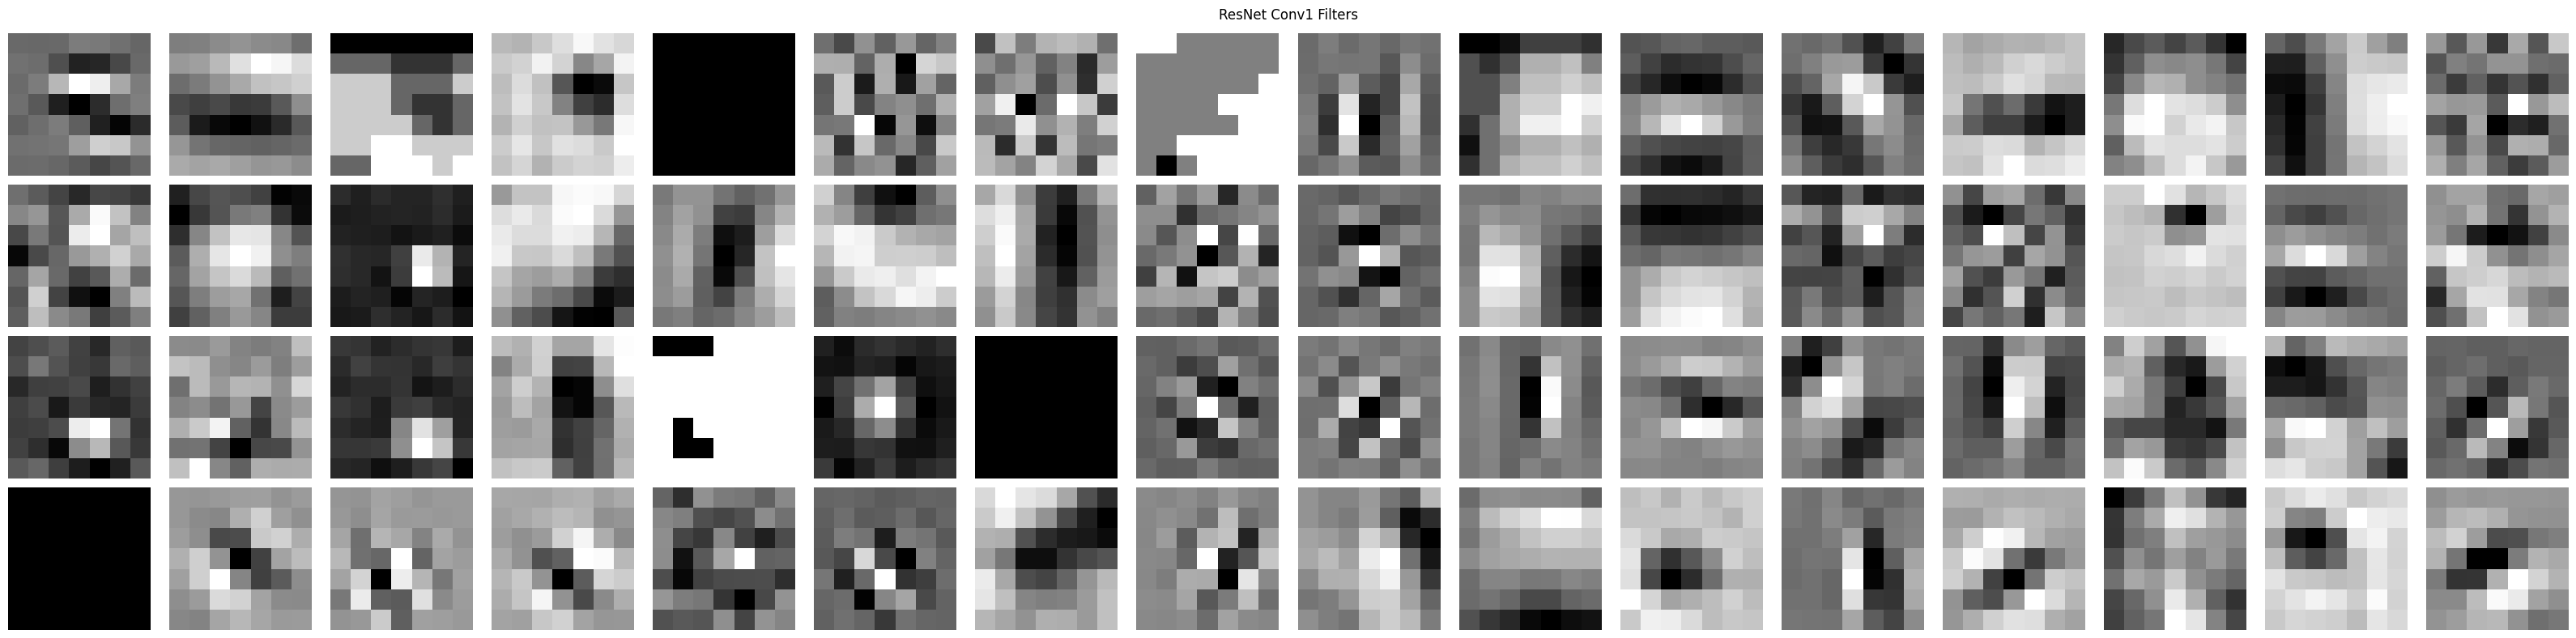

In [26]:
# Visualize filters of the first conv layer of ResNet.
visualize_filters(model.conv1, title="ResNet Conv1 Filters")

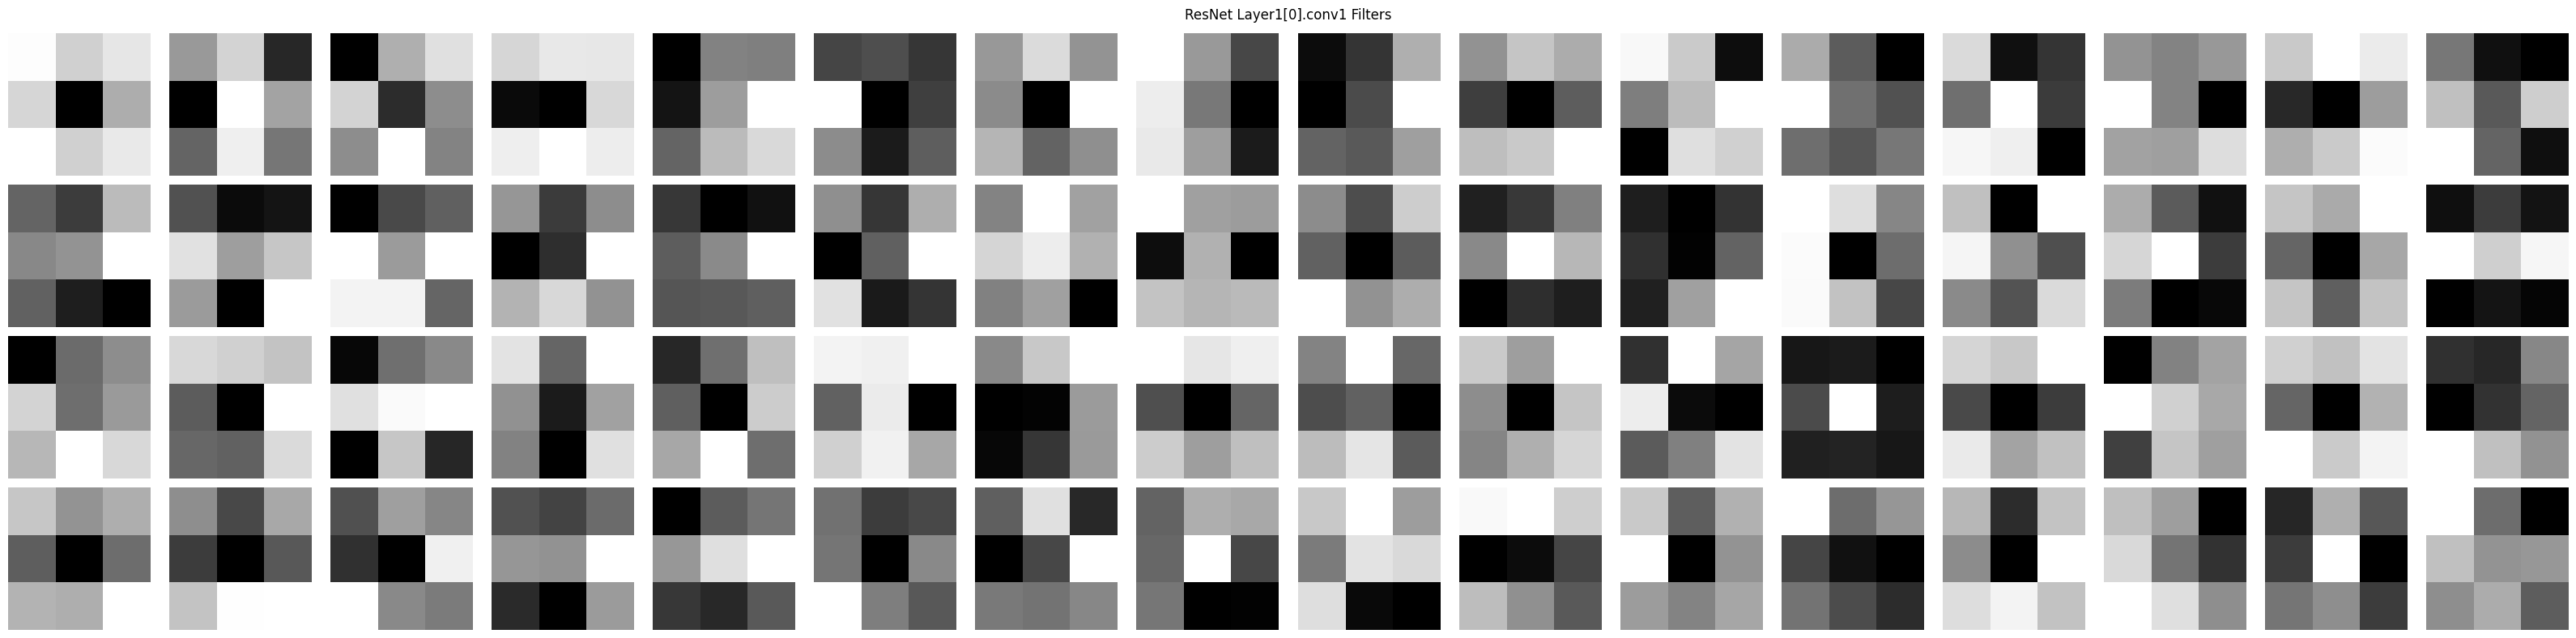

In [27]:
# Let's also visualize filters of a second layer, e.g., model.layer1[0].conv1
# This is a deeper layer in ResNet.
visualize_filters(model.layer1[0].conv1, title="ResNet Layer1[0].conv1 Filters")

In [29]:
import math

def visualize_feature_maps(model, layer_func,  title="Feature Maps"):
    # This function passes one image through the model up to a given layer_func and shows the feature maps.
    # layer_func is a function that takes an input x and returns the output after the desired layer.
    # We also added val_dataset_gray and device as parameters for flexibility.
    model.eval()
    sample_img, _ = val_dataset[0]
    # Take one image from validation set.
    sample_img = sample_img.unsqueeze(0).to(device)
    # Add batch dimension and move to device.
    with torch.no_grad():
        fm = layer_func(sample_img)
        # Get feature maps.
    # Normalize feature maps.
    fm_min, fm_max = fm.min(), fm.max()
    fm = (fm - fm_min) / (fm_max - fm_min)
    fm = fm.squeeze(0).cpu()
    # Shape: (out_ch, H, W)
    out_ch = fm.shape[0]

    # Fixed number of rows
    n_rows = 4
    n_columns = math.ceil(out_ch / n_rows)

    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns*2, n_rows*2))
    fig.suptitle(title)
    axs = axs.flatten()  # Flatten so we can iterate easily

    for i in range(out_ch):
        f_map = fm[i].numpy()
        axs[i].imshow(f_map, cmap='gray')
        axs[i].axis('off')

    # Hide any unused subplots
    for j in range(out_ch, n_rows*n_columns):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()



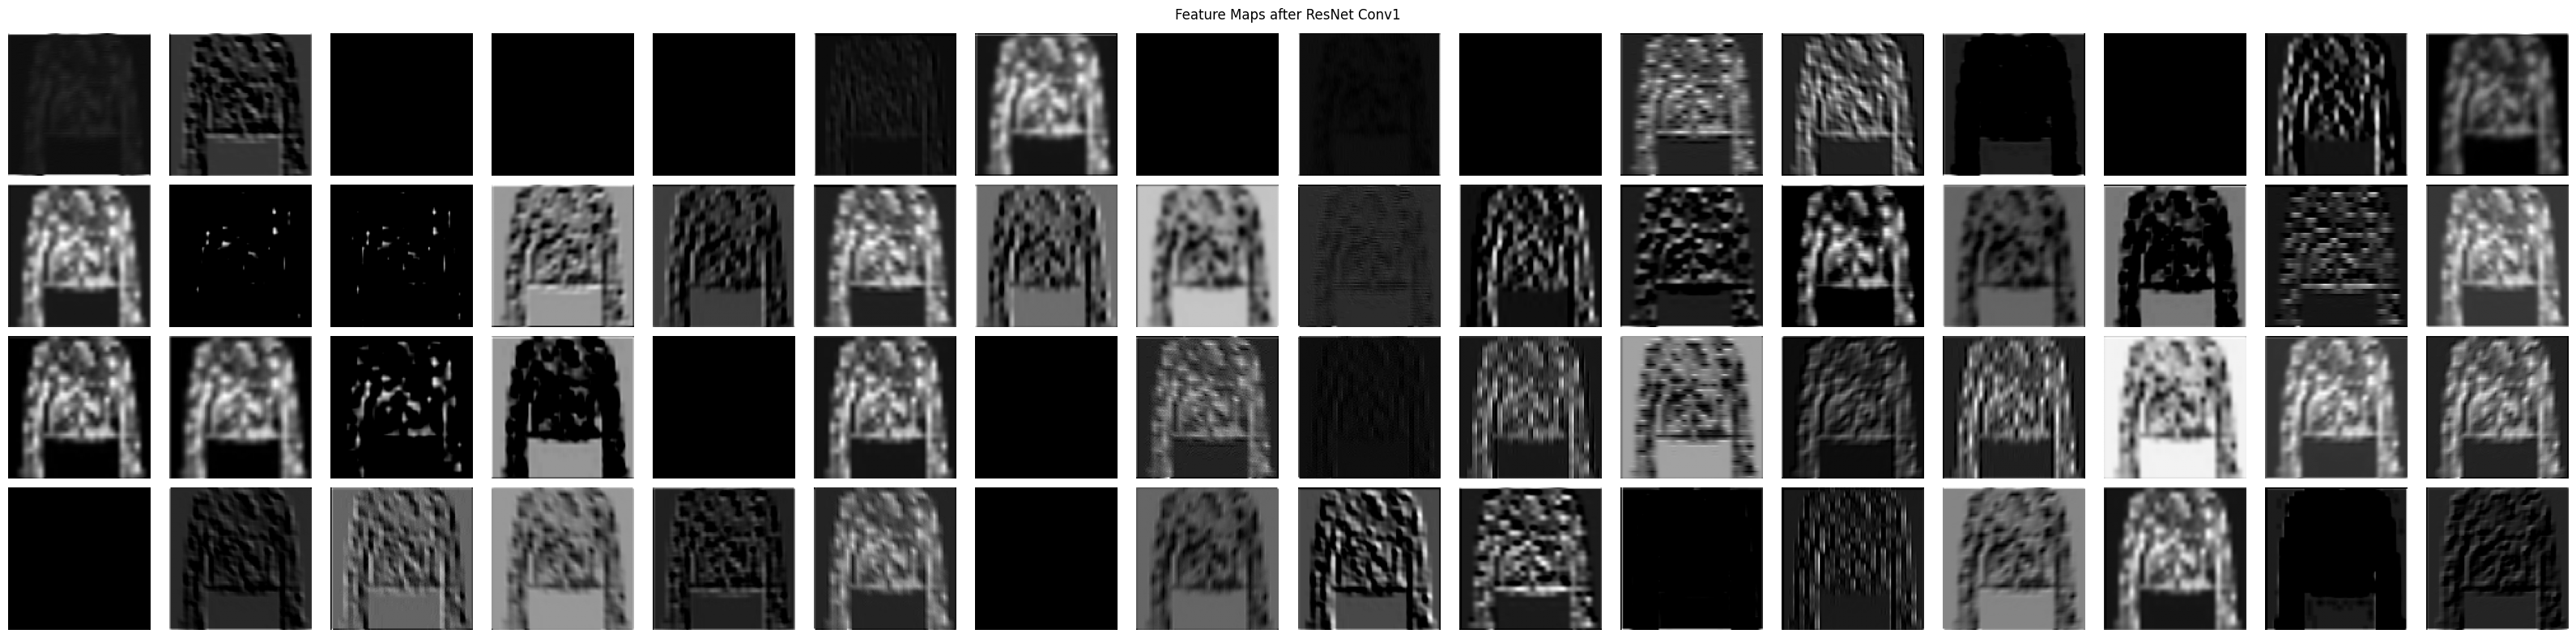

In [30]:
# Define layer_func for conv1 feature maps in ResNet
def conv1_features_resnet(x):
    # Pass x through conv1, bn1, relu, and stop before pool.
    x = model.conv1(x)
    x = model.bn1(x)
    x = torch.relu(x)
    # Not pooling yet, just show after conv1.
    return x

# Visualize feature maps after conv1 in ResNet.
visualize_feature_maps(model, conv1_features_resnet, title="Feature Maps after ResNet Conv1")

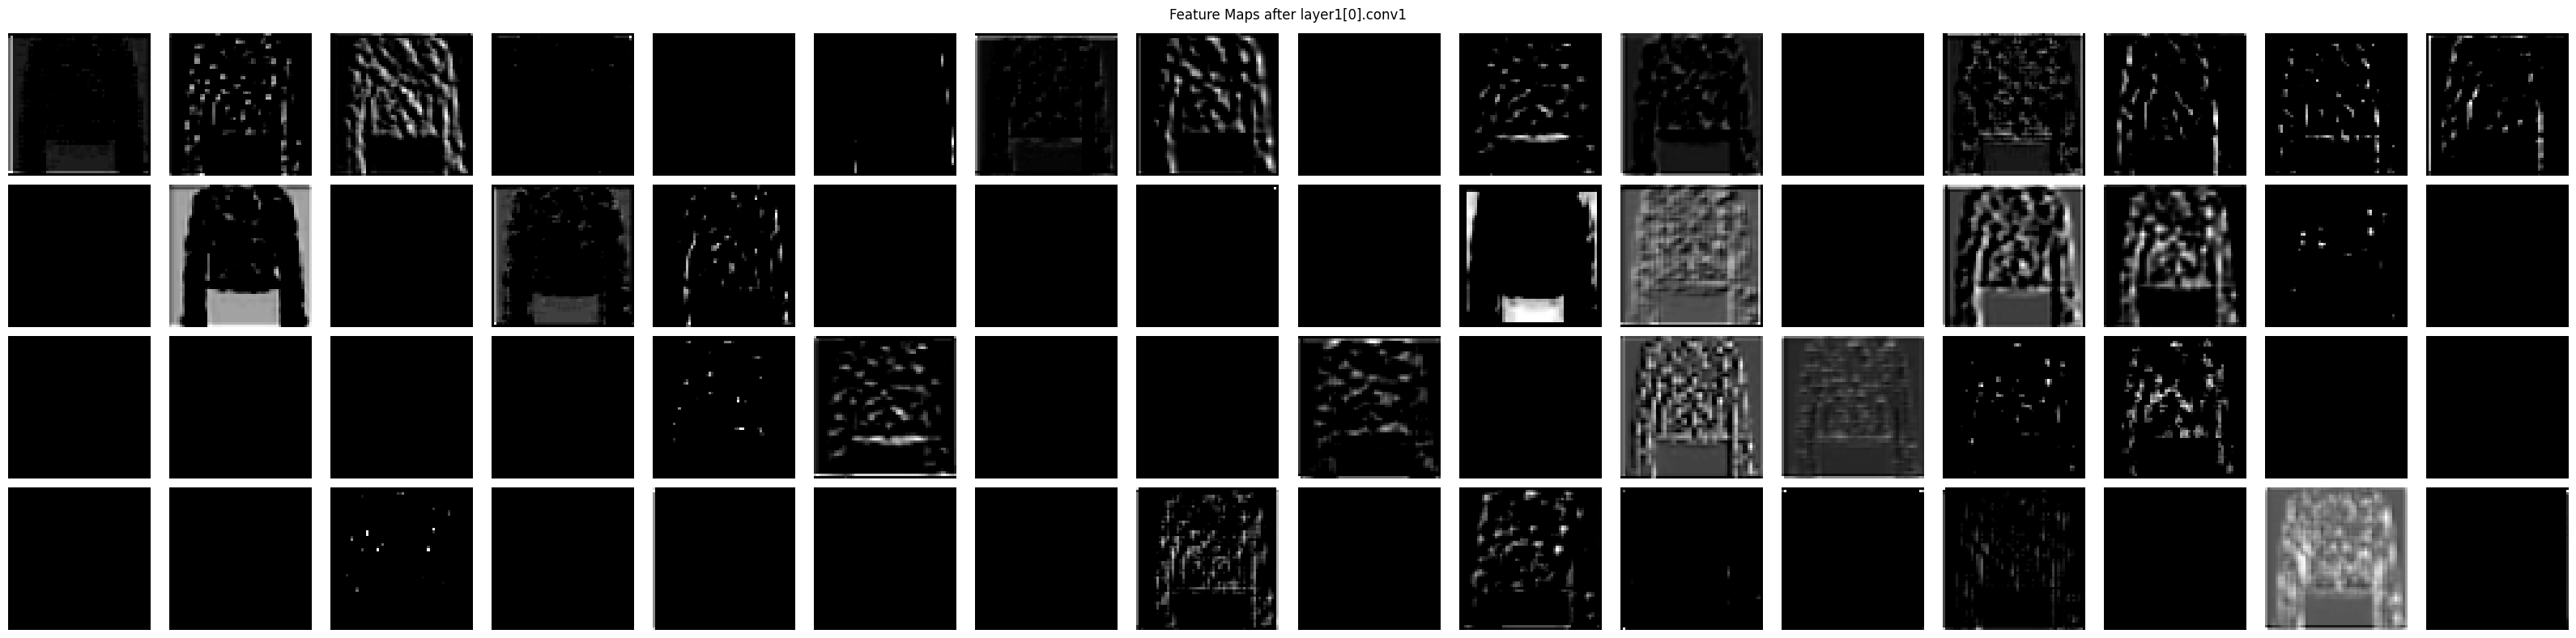

In [31]:
# For the second layer (e.g. model.layer1[0].conv1):
# We need a layer_func that passes data through conv1->bn1->relu->maxpool->layer1[0].conv1 (and its following relu?)
def layer1_conv1_features_resnet(x):
    x = model.conv1(x)
    x = model.bn1(x)
    x = torch.relu(x)
    x = model.maxpool(x)
    # Now pass through layer1[0].conv1 and relu
    x = model.layer1[0].conv1(x)
    x = torch.relu(x)
    return x

visualize_feature_maps(model, layer1_conv1_features_resnet, title="Feature Maps after layer1[0].conv1")